In [1]:
#this notebook reads data from the C program- The format is standard
#presently, we only considere one observable (distinct sites visited). Later we will look at living_particles(t)
#the file contains a header with chunk index, time, systems sizes (L), boundary conditions used (BCs) and moments
#below we plot an example for one system (L=100,BCs=0) of all moments and following that, we plot all systems for M1


In [2]:
#extract manifest from comments if required
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy import optimize
from pylab import *

In [3]:
 #check sample paths (M0 should have CHUNK_SIZE=1000 touches) or whatever the chunk size in the pgoram is
def checkRaw(rawdata):
    pivoted = rawdata.drop_duplicates(subset=['chunk', 't'], keep='first')[['chunk', 't', 'M0', 'M1']].pivot('t','chunk')
    # This is to sort merge files. From all occurrences with same time and chunk time it only keeps the first.
    # Then it puts the first moment into a t/chunk table
    pivoted.replace(0, np.NaN,inplace=True)
    pivoted.fillna(method='ffill',inplace=True)
    # Here the last datapoint is filling up the whole table
    return pivoted

In [4]:
#http://scipy.github.io/old-wiki/pages/Cookbook/FittingData
#http://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i

# This approach uses optimize.leastsq from scipy library
def fit_data_to_time_index(mydata, moment = "M1", range_tup=(10,500), pinit = [6.0, 3.0],ax=plt):
    '''This assumes you want to fit for time - and also that you have one time series e.g. L=100, BC=0 etc.
    ALSO assumes a cut off 
    '''  
    originalIndex = mydata['t']
    
    
    mydata = mydata[(mydata['t'] >= range_tup[0]) & (mydata['t'] <= range_tup[1])]
    
    powerlaw = lambda x, amp, index: amp * (x**index)
    fitfunc = lambda p, x: p[0] + p[1] * x   
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
    
    xdata = mydata['t']
    ydata = mydata[moment].values
    mydata['err'] = mydata.groupby(mydata['t']).std()[[moment]]
    yerr = 0.2 * ydata #mydata['err'].values #bw?
     
    logx = np.log(xdata)
    logy = np.log(ydata)
    logyerr = yerr / ydata
  
    out = optimize.leastsq(errfunc, pinit, args=(logx, logy,logyerr), full_output=1,maxfev=2000) 
    pfinal,covar = out[0], out[1]
    index,amp = pfinal[1],np.exp(1.0)**pfinal[0]

    indexErr,ampErr = np.sqrt( covar[0][0] ) , np.sqrt( covar[1][1] ) * amp
    #fit_vals = powerlaw(xdata, amp, index)
    fit_vals = powerlaw(originalIndex.values[:40], amp, index)
    plt.figure(figsize=(20,10))
    #ax.loglog(xdata, fit_vals) # partial line - the fitted part
    ax.loglog(originalIndex.values[:40], fit_vals)
    ax.errorbar(xdata, ydata, yerr=yerr, fmt='k.') 
    
    print(index,amp)
    return index, amp

In [5]:
#helper function, foreach M_n, compute M_n/M_0 and take the average over all the chunks 
#(later useful to look at error bars)
#compare taken the moments and averaging vs summing and then taking the moment
def apply_div_compute_moments(df):
    df = df.drop_duplicates(subset=['chunk', 't'], keep='first')
    moments = [ "M"+str(i+1) for i in range (8)]
    for m in moments:
        df[m+"M0"] = df[m]/df['M0']    
    piv = df.pivot('t','chunk')   
    cols = []
    for m in moments:
        piv[m+"mean"] = piv[m+"M0"].mean(axis=1)
        cols.append(m+"mean") 
    return piv[cols].xs('', level='chunk', axis=1)#set t on index and drop down a level from chunks

In [6]:
def plotMoment(rawdata, M=1, lim = 10000000):
    #system sizes on the first moment
    M = "M"+str(M)
    systems = rawdata[['chunk', 't', 'M0', M, 'L']]
    systems[M+'M0'] = systems[M]/systems['M0']
    data =systems.groupby(['L','t']).mean()[[M+'M0']].reset_index().pivot('t', 'L', M+'M0')
    return data.plot(logx=True,logy=True,figsize=(20,10), xlim=(0,lim))

In [7]:
def df_to_latex_table(df):
    print('\\begin{center}\\begin{tabular}')
    print("{|"+ "|".join(['c' for i in range(len(df.columns))]) +"|}")
    print('\\hline')
    print( " & ".join([ "\\textbf{" + str(v) + "}" for v in df.columns]) )
    print('\\\\')
    print('\\hline')
     
    for i,r in df.iterrows():
        print( " & ".join(["%.2f" % v for v in r]) )
        print('\\\\')
    print('\\hline')
    print('\\end{tabular}\\end{center}')
  

In [8]:
  
def readTraceHistoryFromFile(f):
    # This does soemthing to #TRACE_HIST
    ld = {}
    DFs = [None]
    with open(f) as f:
        for line in f:
            chk = "#TRACE_HIST_L="
            if line[0:len(chk)] == chk:
                data = line[len(chk):-1]
                res = data.split(':')
                #print(res)
                L = int(res[0])
                    
                dlst = []
                for d in res[1].split(' '):
                    if d.isdigit():
                        dlst.append(float(int(d)))

                digitized = np.bincount(dlst)
                D = pd.DataFrame(digitized, columns = ["L"+str(L)])
                #D['L'] = L
                DFs.append(D)

                    
                
    return pd.concat(DFs,axis=1).fillna(0)

In [9]:
# df=readTraceHistoryFromFile('C:/Users/sirsh/Documents/Code/C/BWS_GITLAB/BranchingWienerProcess/BWS_VS_PROJECT/BWS/out.data')
# df

In [10]:
# # Read in data
# #df = pd.DataFrame([[1,2,3],[4,5,6]], columns= ['a','b','c'])
# #df
# #df_to_latex_table(df)
# data = readTraceHistoryFromFile('C:/Users/sirsh/Documents/Code/C/BWS/BWS_VS_PROJECT/BWS/results.out')

# #data.columns = ['h', 'L']
# #data.pivot()
# data[(data>=0) & (data < 3000)][:3000].hist(bins=5, figsize=(20,10))

In [ ]:
from glob import glob
import pandas as pd
data_parts = []
parts = "../data/samples/*.*"
for g in glob(parts):

    if "_4" in g:continue
    print(g)
    data_parts.append(pd.read_csv(g,sep='\t', comment='#',header=None, 
                                  names=["L","D","BCs","t","M0","M1","M2","M3","M4","M5","M6","M7","M8"]))
data_parts = pd.concat(data_parts)
data_parts.index.name="chunk"
data_parts = data_parts.reset_index()
data_parts.head()

In [31]:
data_parts = data_parts.astype(float)

In [32]:
%matplotlib inline

In [33]:
slicedata = data_parts
mn = slicedata.groupby(["L","t"]).mean().reset_index()
#mn=mn[mn.L != 243]

In [34]:
mn.L.unique()
mn.head()

,L,t,chunk,D,BCs,M0,M1,M2,M3,M4,M5,M6,M7,M8
0,9.0,0.100,500.581582,2.0,0.0,1000.0,1009.973974,1030.008008,1070.334334,1151.761762,1316.940941,1654.272272,2349.853854,3803.773774
1,9.0,0.102,500.500000,2.0,0.0,1000.0,1010.198000,1030.680000,1071.902000,1155.120000,1323.878000,1668.360000,2378.222000,3860.640000
2,9.0,0.105,500.500000,2.0,0.0,1000.0,1010.441000,1031.413000,1073.627000,1158.865000,1331.771000,1684.873000,2412.947000,3934.705000
3,9.0,0.107,500.500000,2.0,0.0,1000.0,1010.641000,1032.015000,1075.039000,1161.915000,1338.151000,1698.075000,2440.279000,3991.755000
4,9.0,0.110,500.500000,2.0,0.0,1000.0,1010.868000,1032.700000,1076.652000,1165.420000,1345.548000,1713.580000,2472.972000,4061.740000


In [35]:
ms = [c for c in mn.columns if c.startswith("M") and c != "M0"]
ms
for c in ms:
    mn[c] = mn[c] / mn["M0"]
mn.head()

,L,t,chunk,D,BCs,M0,M1,M2,M3,M4,M5,M6,M7,M8
0,9.0,0.100,500.581582,2.0,0.0,1000.0,1.009974,1.030008,1.070334,1.151762,1.316941,1.654272,2.349854,3.803774
1,9.0,0.102,500.500000,2.0,0.0,1000.0,1.010198,1.030680,1.071902,1.155120,1.323878,1.668360,2.378222,3.860640
2,9.0,0.105,500.500000,2.0,0.0,1000.0,1.010441,1.031413,1.073627,1.158865,1.331771,1.684873,2.412947,3.934705
3,9.0,0.107,500.500000,2.0,0.0,1000.0,1.010641,1.032015,1.075039,1.161915,1.338151,1.698075,2.440279,3.991755
4,9.0,0.110,500.500000,2.0,0.0,1000.0,1.010868,1.032700,1.076652,1.165420,1.345548,1.713580,2.472972,4.061740


0.155651362745 1.22378609513
0.782160966887 0.662103743839
1.59871290139 0.32923499584
2.4196846028 0.210230167712
3.23100421382 0.161157614754
4.0340234258 0.141422870636
4.8300729437 0.138554725678
5.62007439899 0.149214650716


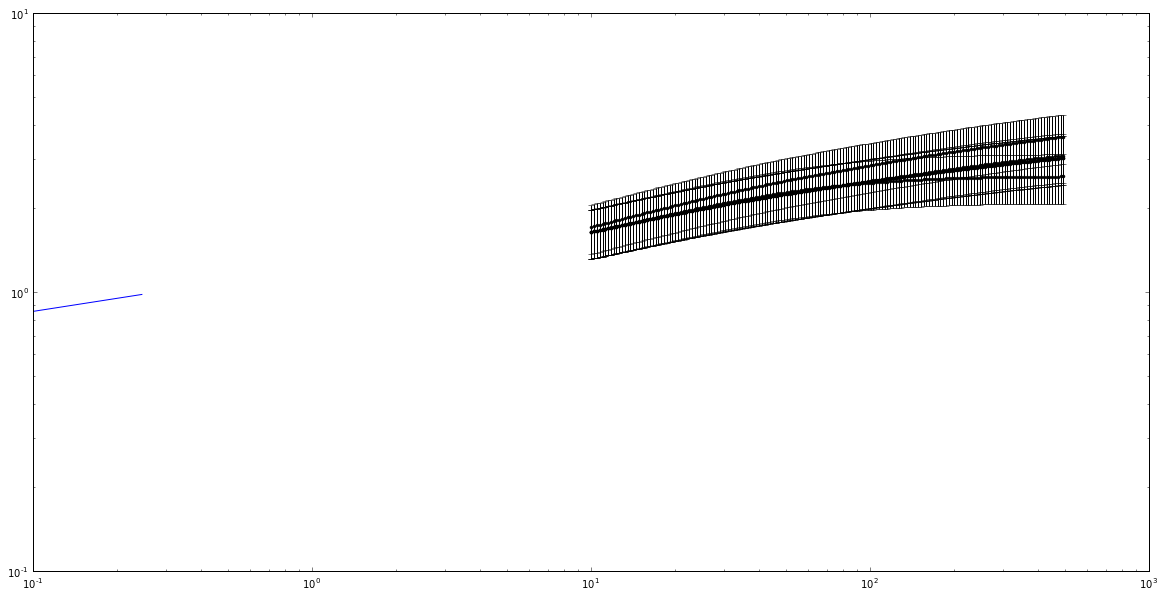

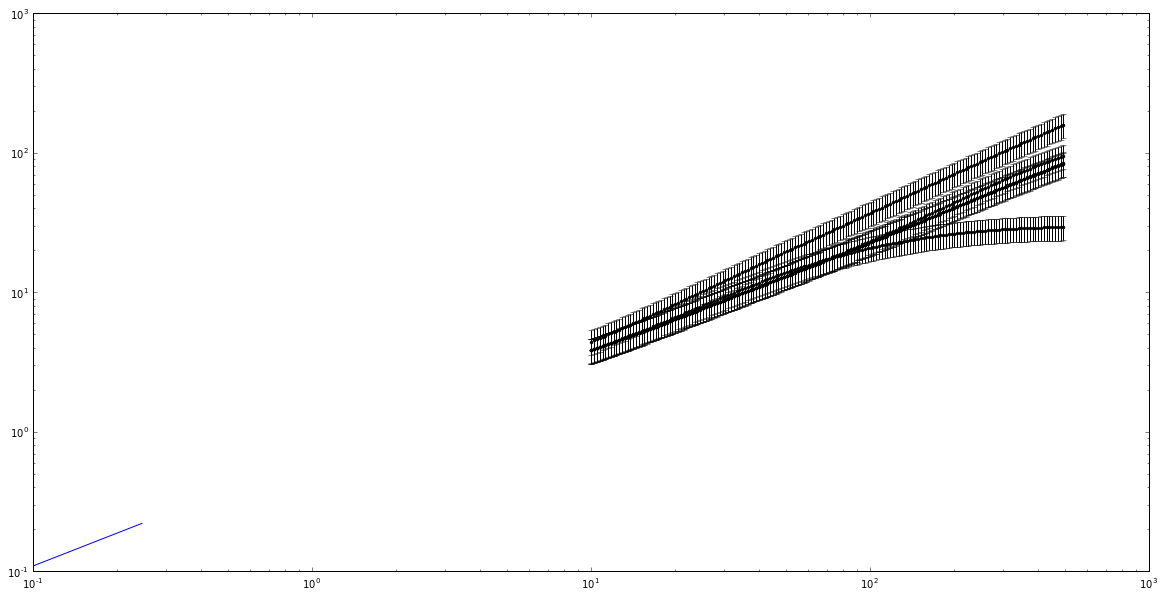

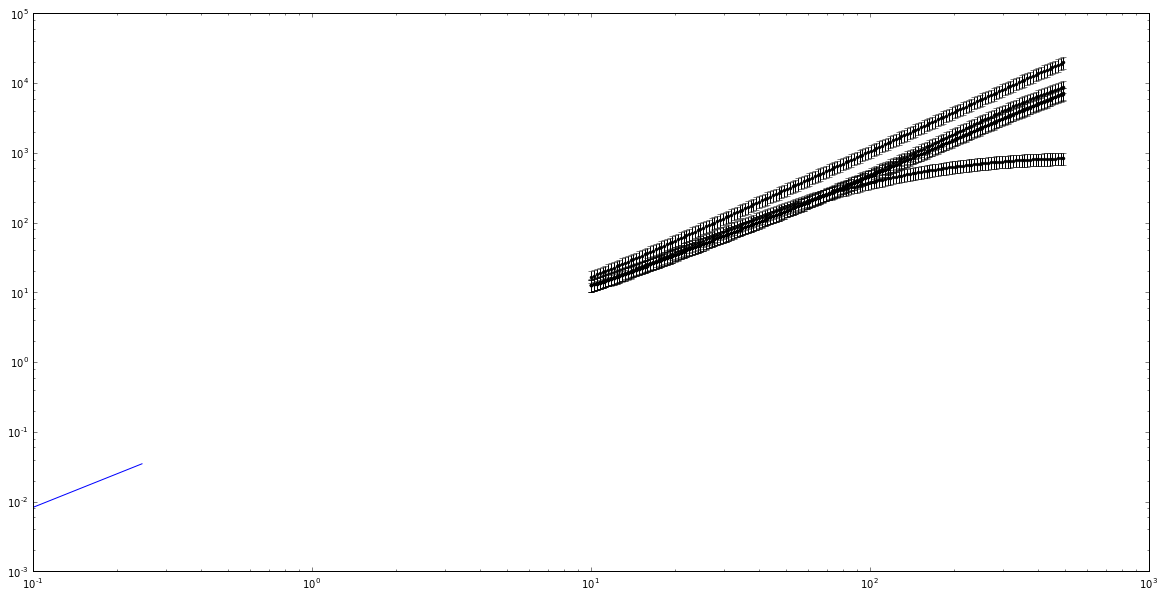

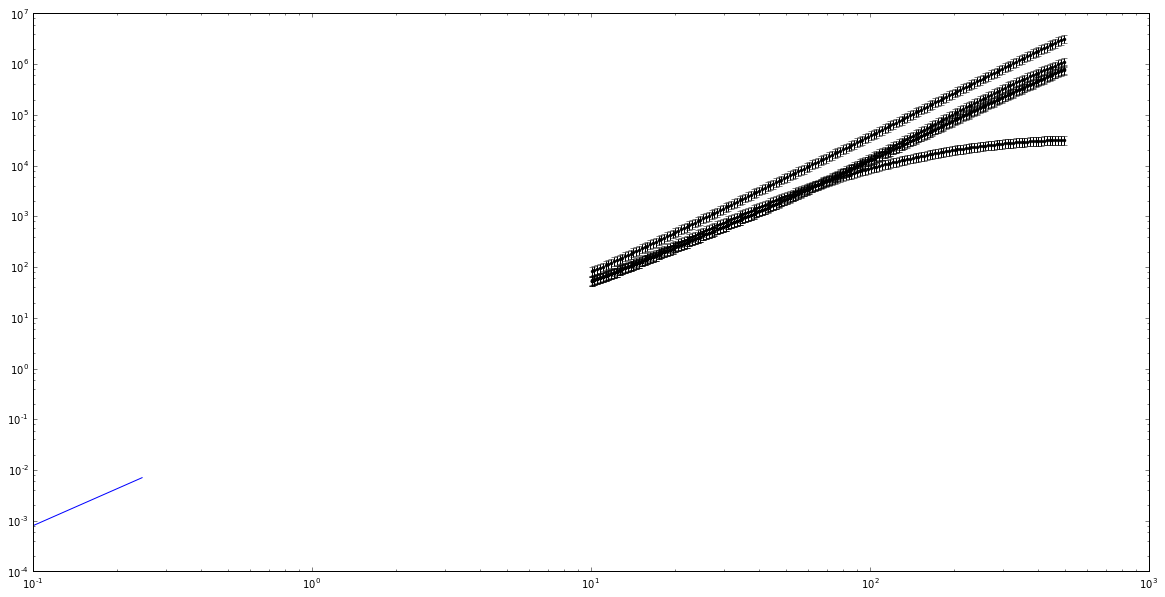

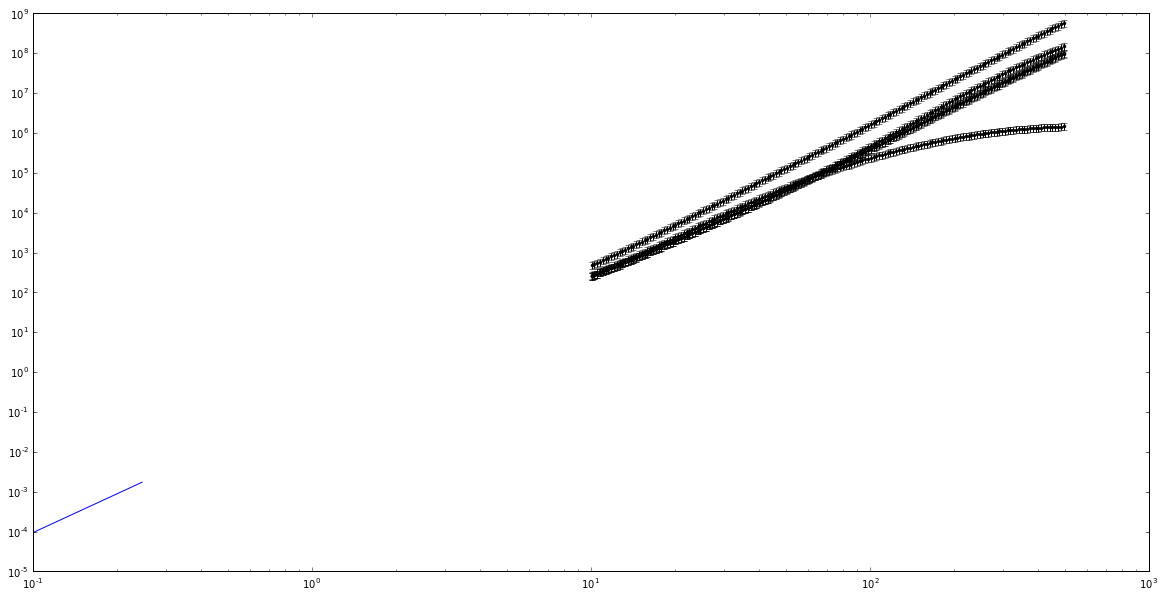

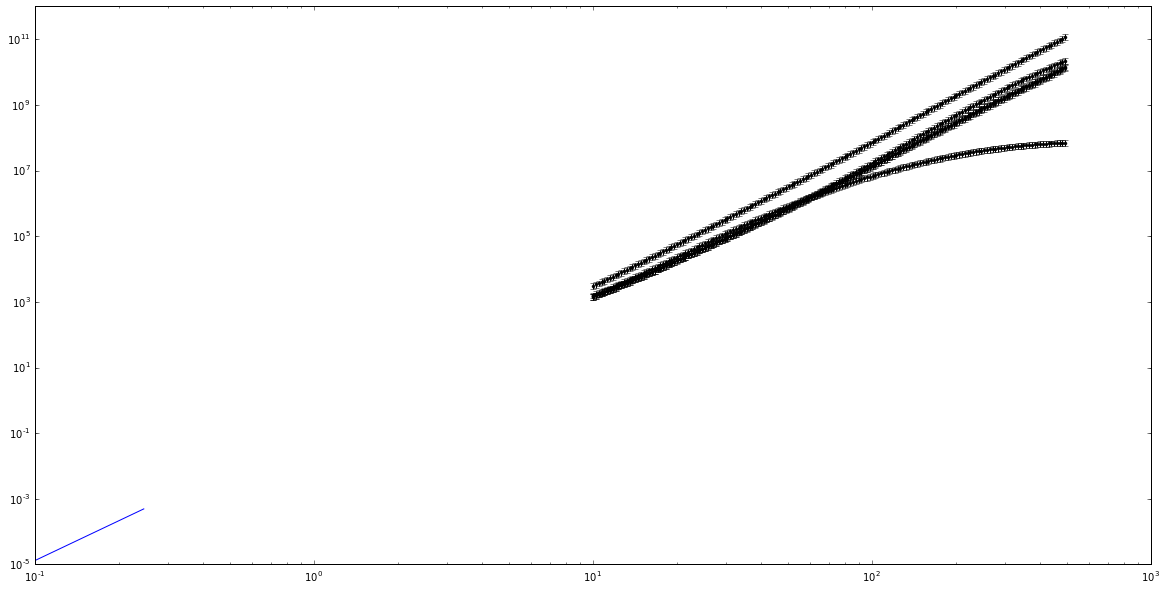

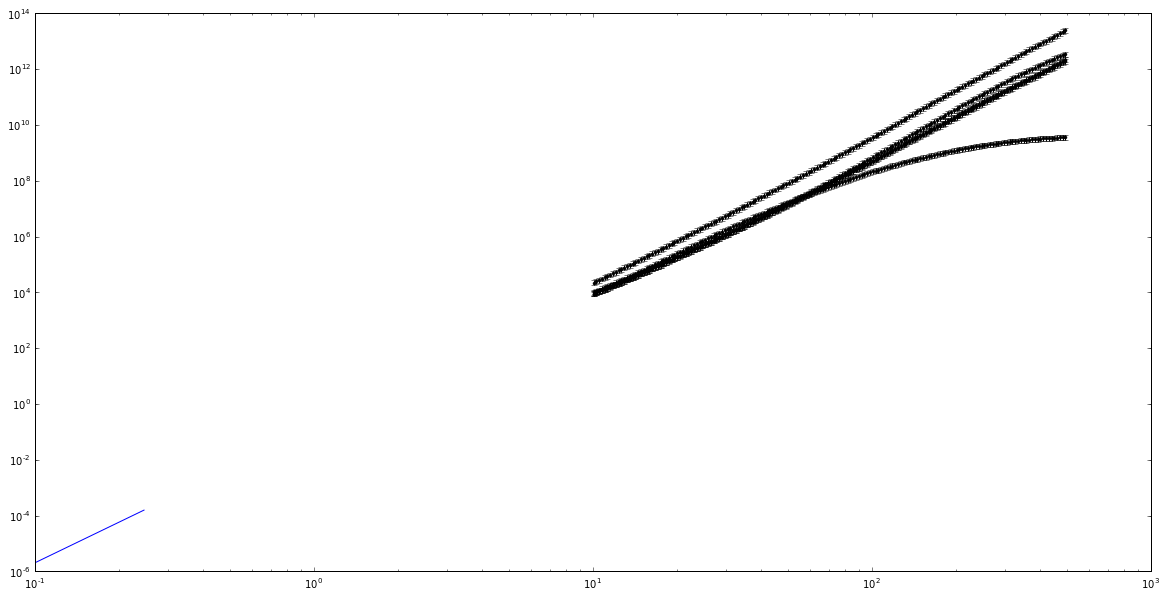

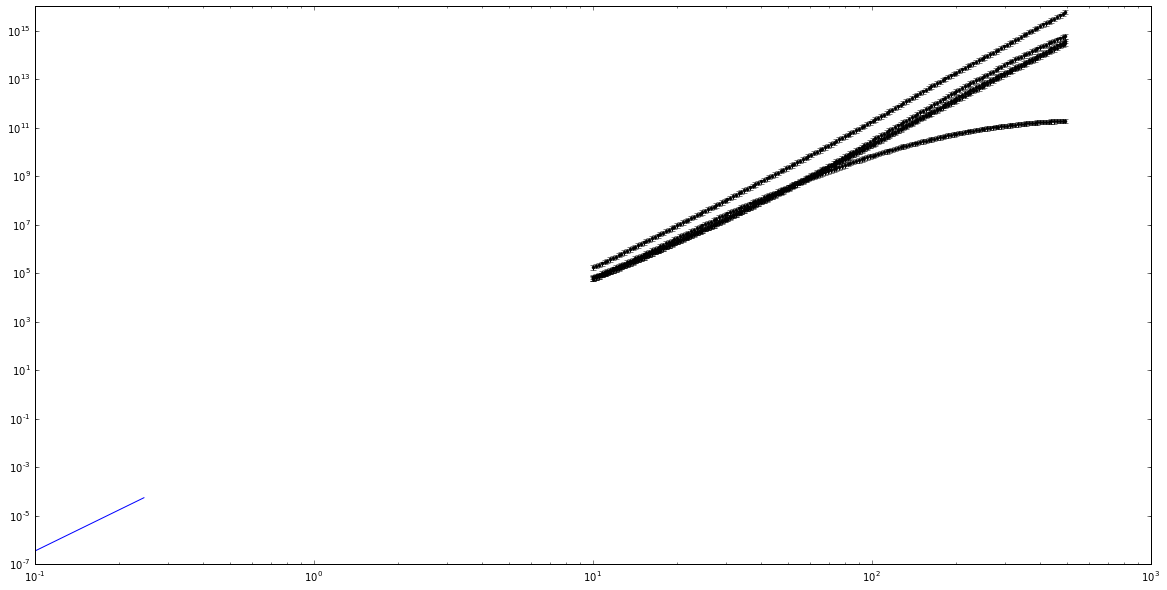

In [36]:
stuffs = []
for m in ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]:
    a,b = fit_data_to_time_index(mn[["t", "L", m]], moment=m)
    stuffs.append([a,b])
st = pd.DataFrame(stuffs)


In [37]:
st["diff"] = st[0].diff()

In [38]:
243/3
81/6

13.5

In [39]:
st

,0,1,diff
0,0.155651,1.223786,NaN
1,0.782161,0.662104,0.626510
2,1.598713,0.329235,0.816552
3,2.419685,0.210230,0.820972
4,3.231004,0.161158,0.811320
5,4.034023,0.141423,0.803019
6,4.830073,0.138555,0.796050
7,5.620074,0.149215,0.790001


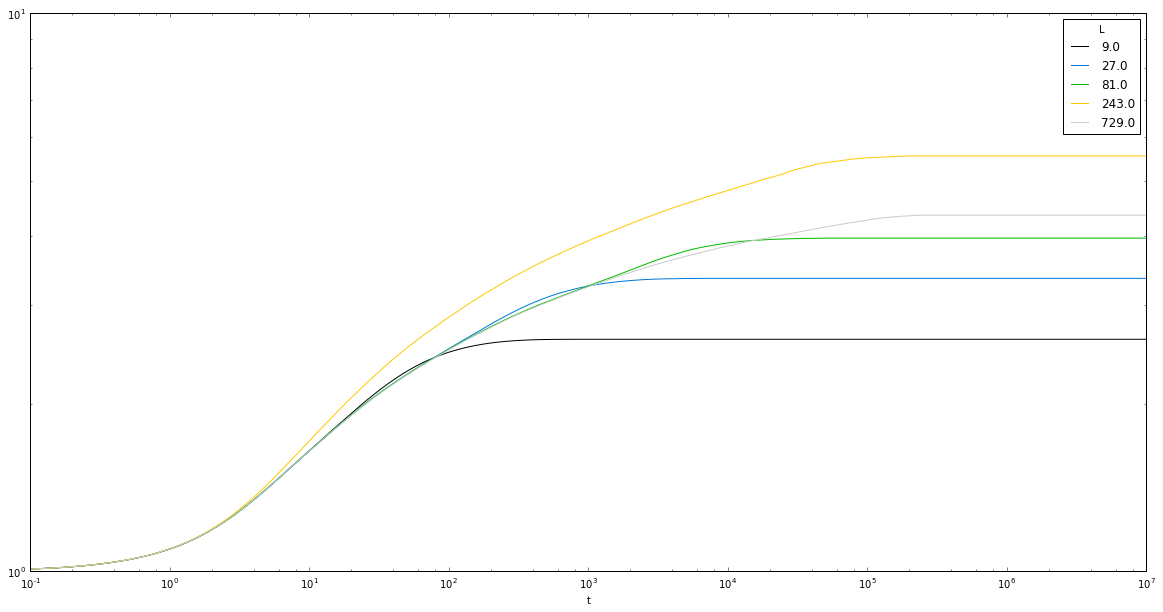

In [40]:
# rawdata = pd.read_csv('~/phd/ftrg/BranchingWienerProcess/data/output_N1e7_D2_L10.out', sep='\t', comment='#') #2d_close_axis_1
# slicedata = rawdata#[(rawdata['L']==100) & (rawdata['BCs']==0)] 
# slicedata.fillna(method='ffill',inplace=True) #safety for blanks
# slicedata = slicedata.astype(float)#double check types (excuse the pun)
# slicedata.to_csv('sliced_data.dat', sep='\t')
#%matplotlib inline
mn.pivot("t", "L", "M1").plot(logx=True,logy=True,figsize=(20,10),xlim=(0,10**7),cmap='spectral')

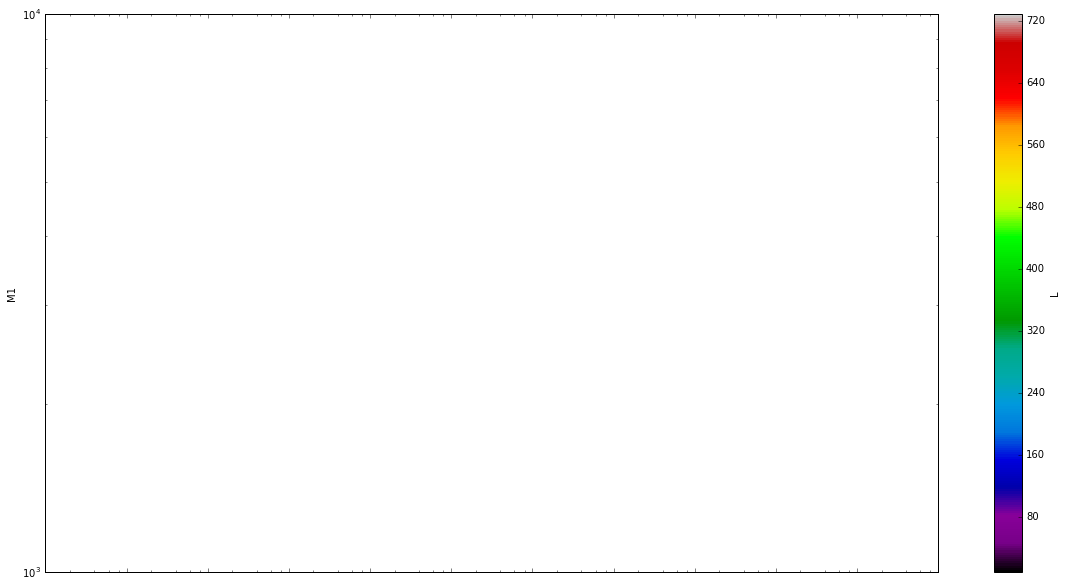

In [41]:
#%matplotlib inline
mn[::10].plot(kind='scatter',x='t',y='M1',cmap='spectral', 
              ylim=(10**3,10**4),
              c='L',figsize=(20,10),logx=True,logy=True)

In [ ]:
#fit simple on log-log of all moments for a given system
#choose suitable ranges within cut-off using range_tuple
##warning - we have hardcoded how much of the fit line to show based
#todo - use higher order fit function - required for moments > 6
fit_tuple = (20,101)
ds = []
print("Available sys data "+str(slicedata['L'].unique()))
for l in slicedata['L'].unique():#slicedata['L'].unique()[:4]:   
    print('collecting for system '+str(l)) #todo enumerate BCs, Ds etc    
    sysdata = slicedata[slicedata['L']==l]
    groupeddata = apply_div_compute_moments(sysdata)
    ax = groupeddata.plot(logx=True,logy=True,figsize=(20,10), xlim=(0,10000))
    groupeddata.to_csv('grouped_data_L'+str(l), sep='\t')
    sysdata.set_index(sysdata['t'],inplace=True)
    for i in range (8):
        d = {}
        d['l'] = l
        M = "M"+str(i+1)
        d['moment'] = str(i+1)
        Moment = M+"M0"        
        sysdata[M+'M0'] = sysdata[M]/sysdata['M0']
        d['i'], d['a'] =  fit_data_to_time_index(sysdata, range_tup=fit_tuple, moment=Moment,ax=ax)    
        ds.append(d)
res = pd.DataFrame(ds) 
res['i_diff'] = res['i'].diff(1)#carefull, only makes sense per group
res.columns = ["Amp", "Index", "L", "Moment n=", "$\Delta$ Index"]
res

In [ ]:
df_to_latex_table(res[["Amp", "Index", "Moment n=", "$\Delta$ Index"]].astype(float))

In [ ]:
groupeddata['M3mean'].plot(logx=True, logy=True)

In [ ]:
#take a look at the different systems in the region
groupeddata[10:1000].plot(kind='line', logx=True, logy=True)

In [ ]:
M = 1
buff = rawdata["M"+str(M)]/rawdata['M0']
len(buff)

In [ ]:
#plot the a given moment M and suggest an L-agnostic exponent for a given region e.g. t:(10,30)
M = 1
M_Name = 'M'+str(M)+"M0"
print(M_Name)
rawdata.set_index(rawdata['t'],inplace=True)
ax = plotMoment(rawdata, M=M, lim=10000)
rawdata[M_Name] = rawdata["M"+str(M)]/rawdata['M0']
fit_data_to_time_index(rawdata, range_tup=(6,20), moment=M_Name,ax=ax)    


In [ ]:
rawdata.


In [ ]:
#todo: tigher fits, trace histogram, above can be re-used for any L,BC, D etc. - later reuse for obs=pop_size

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

data_m = data.as_matrix()
x,y = np.meshgrid(data_m.shape[0],data_m.shape[1])

z = data.values
zs = []
for x in range(len(x)):
    for y in range(len(y)):
        zs.append(z[x,y])
        
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
data